### __0. 오늘의 집 대시보드__
* 가구 카테고리별 대시보드 
* wordcloud
* statistics
* raddar chart
* sankey chart
* url

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import re
import os
import sys 
import json

!pip install git+https://github.com/haven-jeon/PyKoSpacing.git
!pip install konlpy
!pip install soynlp

from pykospacing import Spacing
from konlpy.tag import Kkma, Komoran, Okt, Mecab
import soynlp

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
import re
import collections
import itertools
!pip install lda
import lda
import requests
import csv
import time
import math
import operator
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
from collections import defaultdict
from pandas import read_table
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-3ix4rc2a
  Running command git clone -q https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-3ix4rc2a
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 351 kB 5.1 MB/s 
     |████████████████████████████████| 99 kB 8.5 MB/s 


### __1. wordcloud__
* wordrank 알고리즘을 이용해서 가구별 리뷰 키워드 추출 후 워드 클라우드로 시각화

### 전처리

In [ ]:
# 데이터 불러오기
import pandas as pd
df = pd.read_csv('/content/drive/Shareddrives/컨퍼런스/clus_pororo_final.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
print(df.shape)
df.head()

(1237892, 23)


,user,date,total_score,dur_score,price_score,design_score,delivery_score,options,review,help_count,item_name,item_brand,item_sale_price,item_category1,item_category2,item_category3,item_score,item_count,review2,n1,n2,n3,n4
0,카호3,2021.12.26 ∙ 오늘의집 구매,5.0,5.0,5.0,5.0,5.0,상품명: A사이드테이블 / 색상: 우드,정말 사길 잘했어요! 침대 높이와도 딱 맞구!! 집이 아이보리와 베이지? 느낌이라 ...,2,당일출고 순수원목 A사이드테이블 3colors,먼데이하우스,18900,테이블/책상,사이드테이블,사이드테이블,4.6,36825,정말 사길 잘했어요! 침대 높이와도 딱 맞고!! 집이 아이보리와 베이지? 느낌이라 ...,3.4,3.400,3.4,3.40
1,GuYung,2021.12.23 ∙ 오늘의집 구매,5.0,5.0,5.0,5.0,5.0,상품명: A사이드테이블 / 색상: 화이트,깔끔하고 예뻐서 마음에 들어요!!!!,2,당일출고 순수원목 A사이드테이블 3colors,먼데이하우스,18900,테이블/책상,사이드테이블,사이드테이블,4.6,36825,깔끔하고 예뻐서 마음에 들어요!!!!,3.4,3.400,3.4,3.40
2,코코짱2222,2021.12.22 ∙ 오늘의집 구매,5.0,4.0,5.0,4.0,5.0,상품명: A사이드테이블 / 색상: 화이트,조립이 생각보다 힘들어서 당황했지만 두명이서 하니 괜찮네요! 가격도 저렴하고 이뻐요!,2,당일출고 순수원목 A사이드테이블 3colors,먼데이하우스,18900,테이블/책상,사이드테이블,사이드테이블,4.6,36825,조립이 생각보다 힘들어서 당황했지만 두 명이서 하니 괜찮네요! 가격도 저렴하고 이뻐요!,3.4,3.285,3.4,4.45
3,Sionyeah,2021.12.13 ∙ 오늘의집 구매,5.0,4.0,3.0,5.0,5.0,상품명: A사이드테이블 / 색상: 우드,이쁘고 심플합니다. 근데 조립이 어엄청 힘들어요 남자친구가 해줬는데 힘들어하더라구요ㅋㅋㅠ,2,당일출고 순수원목 A사이드테이블 3colors,먼데이하우스,18900,테이블/책상,사이드테이블,사이드테이블,4.6,36825,이쁘고 심플합니다. 근데 조립이 어 엄청 힘들어요 남자친구가 해줬는데 힘들어하더라고...,3.4,3.120,3.4,3.40
4,건동2,2021.12.09 ∙ 오늘의집 구매,5.0,5.0,5.0,5.0,5.0,상품명: A사이드테이블 / 색상: 우드,상품조립하는것만 10분정도걸랴요 가격대비 좋아요,2,당일출고 순수원목 A사이드테이블 3colors,먼데이하우스,18900,테이블/책상,사이드테이블,사이드테이블,4.6,36825,상품 조립하는 것만 10분 정도 걸랴요 가격 대비 좋아요,3.4,2.720,3.4,3.89


In [ ]:
# 1. 가구별 리뷰 생성 
name_list = df['item_category1'].unique().tolist()
for i, name in enumerate(name_list):
  globals()['df{}'.format(i+1)] = df[df['item_category1']==name].reset_index(drop=True)

In [ ]:
# 2. 가구별 리뷰 전처리
from konlpy.tag import Okt, Kkma, Komoran

okt = Okt() 
kkma = Kkma()
kom = Komoran() # 왠지 모르겠는데 인코딩 오류남

def preprocess_review(review):
    total_review = ''
    #인풋리뷰
    for idx in range(len(review)):
        sentence = review[idx]
        #하나의 리뷰에서 문장 단위로 전처리
        #sentence = re.sub(name.split(' ')[0],'',r)
        #sentence = re.sub(name.split(' ')[1],'',sentence)
        sentence = re.sub('\n','',sentence)
        sentence = re.sub('\u200b','',sentence)
        sentence = re.sub('\xa0','',sentence)
        sentence = re.sub('([a-zA-Z])','',sentence)
        sentence = re.sub('[ㄱ-ㅎㅏ-ㅣ]+','',sentence)
        sentence = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','',sentence)
        if len(sentence) == 0:
            continue
        sentence = okt.pos(sentence, stem=True)
        word = []
        for i in sentence:
            if not i[1] == 'Noun':
                continue
            if len(i[0]) == 1:
                continue
            word.append(i[0])
        word = ' '.join(word)
        word += '. '
        total_review += word
    return total_review.split('. ')

### 키워드 추출

In [ ]:
!pip install KRWordRank
from krwordrank.word import summarize_with_keywords

In [ ]:
# 가구별 키워드 추출 함수 정의
def item_keyword(df, stopwords):
  review = df['review2']
  texts = preprocess_review(review)
  stopwords = {'그래도', '너무', '맘에', '리뷰', '들어', '진짜','마음', '살짝'}
  keywords = summarize_with_keywords(texts, min_count=5, max_length=10,
           beta=0.85, max_iter=10, stopwords=stopwords, verbose=True)
  return keywords

### 워드 클라우드

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# 가구별 워드 클라우드 함수 정의

def item_wordcloud(df, stopwords, keywords):

  def color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl({:d},{:d}%, {:d}%)".format(np.random.randint(190,210),np.random.randint(90,110),np.random.randint(50,70)))

  icon = Image.open('/content/drive/MyDrive/boaz/오늘의집가구별리뷰워드클라우드/house_shape_logo-removebg-preview.png')

  mask = Image.new("RGB", icon.size, (255,255,255))
  mask.paste(icon,icon)
  mask = np.array(mask)

  font_path='/content/drive/MyDrive/NanumSquareB.ttf'
  stopwords = {'그래도', '너무', '맘에', '리뷰', '들어', '진짜','마음', '살짝'}
  passwords = {word:score for word, score in sorted(
             keywords.items(), key=lambda x:-x[1])[:300] if not (word in stopwords)}
  krwordrank_cloud = WordCloud(
                     font_path = font_path,
                     width = 800,
                     height = 800,
                     background_color="white",
                     mask = mask
                     )
  krwordrank_cloud = krwordrank_cloud.generate_from_frequencies(passwords)

  fig = plt.figure(figsize=(10, 10))
  plt.imshow(krwordrank_cloud.recolor(color_func=color_func), interpolation="bilinear")
  plt.axis('off')  
  plt.savefig('wc_가구.png')
  return plt.show()

### 최종

scan vocabs ... 
num vocabs = 3062
done
{'조립': 86.59275669190433, '가격': 24.53982455146346, '배송': 23.194557572752842, '침대': 20.164702455542656, '유리': 19.574122709496972, '나사': 15.599723482610763, '디자인': 15.246430003651978, '생각': 14.912746082490601, '협탁': 13.963357624379492, '조금': 12.087970250708215, '사용': 9.696867729871196, '혼자': 9.368870134030931, '가성': 9.205700870375939, '나무': 8.982026994216612, '부분': 8.773406879198362, '구매': 8.449274254513456, '정말': 8.127116886563813, '대비': 7.395042929707016, '그냥': 7.2377089413236755, '제품': 7.185143554622964, '하나': 7.064343883272336, '사이': 6.889407810481482, '분위기': 6.615416670329657, '여자': 6.510878940393093, '아주': 5.8073863431664225, '정도': 5.516353153115156, '완성': 5.375811864719129, '테이블': 5.239866966674651, '인테리어': 5.047832161274324, '구멍': 5.034999502567645, '구성': 4.627812759363659, '우드': 4.340363346967697, '느낌': 4.182823519880602, '사진': 4.1797838656189565, '크기': 4.118221593543397, '만족': 4.097941173480997, '원목': 4.066373310481919, '추천': 3.8656609880

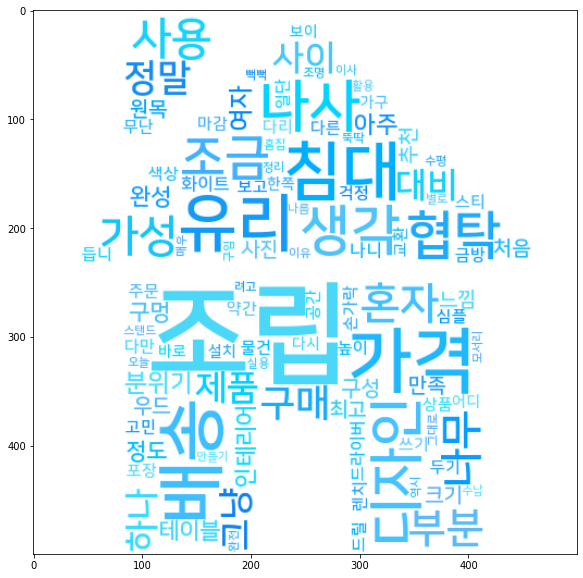

In [ ]:
# 테이블/책상
df1_copy = df1[:30000]
keywords = item_keyword(df1_copy, stopwords)
print(keywords)
item_wordcloud(df1_copy, stopwords, keywords)

scan vocabs ... 
num vocabs = 3065
done
{'의자': 52.47271841398153, '생각': 34.12003202166541, '조립': 28.852969894633564, '배송': 27.896127503825472, '디자인': 19.715368941568507, '가격': 16.740098224484576, '구매': 14.10462865896995, '사용': 12.166483770244076, '부분': 11.291422724669196, '쿠션': 9.586759919755057, '투명': 9.456201457099947, '하나': 8.911906305210064, '정말': 8.45211060445995, '소리': 8.200896251864204, '조금': 8.07138921005144, '느낌': 7.17540894724585, '다리': 7.1525224890453405, '인테리어': 7.069808808784534, '그냥': 7.02627359725767, '아주': 6.350205523185412, '구성': 6.347369630580361, '가성': 6.218776387474795, '식탁': 6.172661485535942, '화이트': 6.15412644924172, '무게': 5.858382401254952, '고민': 5.81501892005339, '테이블': 5.8134912757108, '주문': 5.791291483331959, '색상': 5.6609668389939465, '접이식': 5.441873234178953, '엉덩이': 5.3506632446822415, '대비': 5.296074481666928, '사진': 4.644044487452667, '방석': 4.630100235018162, '걱정': 4.5472901174039775, '다른': 4.486304434318126, '제품': 4.479225691521215, '정도': 4.418093795056144, 

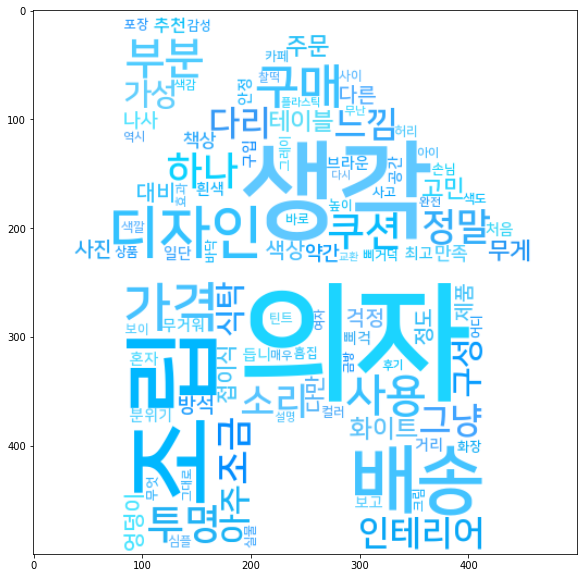

In [ ]:
# 의자
df2_copy = df2[:30000]
keywords = item_keyword(df2_copy, stopwords)
print(keywords)
item_wordcloud(df2_copy, stopwords, keywords)

scan vocabs ... 
num vocabs = 3789
done
{'배송': 33.30985849062685, '소파': 32.30042478534644, '생각': 31.132423861004106, '사용': 25.93322898648953, '침대': 17.59733956518322, '가격': 17.402390491427028, '쿠션': 16.515283102519778, '구매': 13.105586025314894, '정말': 12.161309889858202, '부분': 11.09951644391316, '조절': 10.547345695173405, '조금': 9.973803342967704, '색상': 9.760087399302579, '정도': 9.593014487803162, '냄새': 9.463212536380246, '디자인': 9.112541470344272, '의자': 8.93450596400929, '사이즈': 8.924994000749958, '가성': 7.90392017287333, '제품': 7.867972772444305, '아주': 7.714779250028885, '그냥': 7.581649381551968, '하나': 7.396561958344518, '각도': 7.2684663263393725, '크기': 7.089510129590586, '베드': 6.946678063357325, '주문': 6.815041867935294, '느낌': 6.76568024238056, '대비': 6.7198927400165065, '사진': 6.298542603398936, '허리': 6.186027806711115, '친구': 5.938778018861296, '혼자': 5.608340083989853, '만족': 5.266053672080619, '쓰기': 5.250276639754191, '바닥': 5.187055441064786, '고민': 5.185264789022852, '커버': 5.166938880439603, '손

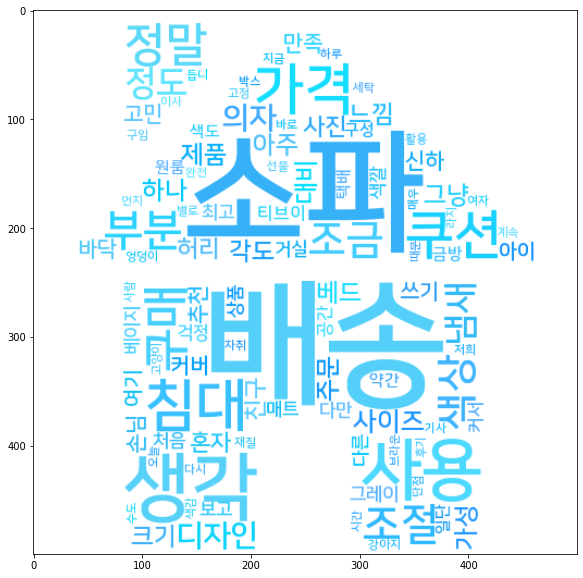

In [ ]:
# 소파
df3_copy = df3[:30000]
keywords = item_keyword(df3_copy, stopwords)
print(keywords)
item_wordcloud(df3_copy, stopwords, keywords)

scan vocabs ... 
num vocabs = 3555
done
{'배송': 46.92691199339672, '매트': 38.90424379019248, '사이즈': 33.97343363198241, '침대': 25.23960565402674, '생각': 18.853130663927438, '사용': 18.01571252291733, '싱글': 16.7666282439394, '나무': 16.733107256428358, '구매': 15.315354922886197, '냄새': 13.192066930015802, '가격': 13.056052787708708, '설치': 11.30966774062268, '조금': 11.076314100380639, '부분': 10.95425345588004, '주문': 10.871099578958528, '그냥': 10.850540038864748, '슈퍼': 9.075533723951393, '기사': 8.982219785029967, '원목': 8.448980112998731, '정도': 8.002810400619955, '혼자': 7.773623697533932, '디자인': 6.982683238479893, '정말': 6.8875053598203495, '바닥': 6.87716863001663, '제품': 6.613393137503874, '걱정': 6.069298569513078, '아주': 5.907773159523217, '먼지': 5.873758731561783, '소리': 5.243849236567344, '하나': 5.170179709246023, '느낌': 5.142137029872854, '프레임': 5.076416146715947, '가성': 4.952746384359954, '사진': 4.8573918525382975, '구성': 4.843221351717216, '곰팡이': 4.8406357278351955, '마감': 4.7595582448695914, '처음': 4.753024070132

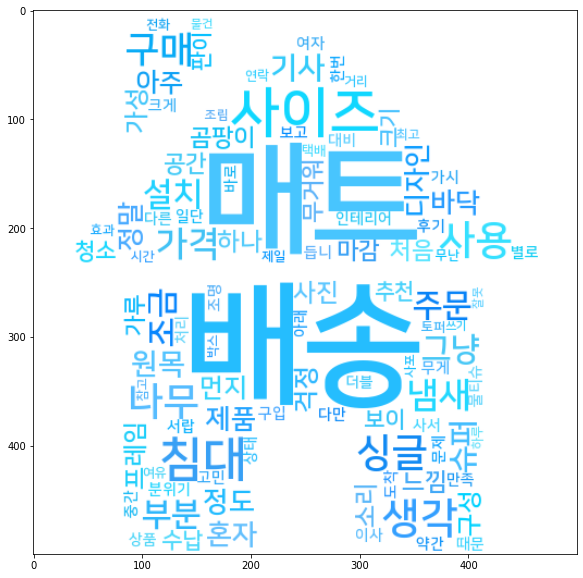

In [ ]:
# 침대
df4_copy = df4[:30000]
keywords = item_keyword(df4_copy, stopwords)
print(keywords)
item_wordcloud(df4_copy, stopwords, keywords)

scan vocabs ... 
num vocabs = 3921
done
{'배송': 58.282066847390695, '수납': 39.69154166627326, '화장': 39.49473006815309, '거울': 25.70885774990146, '가격': 24.828762694105237, '생각': 23.45872675578666, '공간': 21.864011959119964, '기사': 19.247438490726566, '디자인': 19.04133550703437, '서랍': 18.98215242533355, '설치': 12.556832881132603, '부분': 12.222138484128747, '사용': 12.027020721123192, '정말': 10.101458795303401, '조금': 10.033294722882532, '구매': 9.580419480705826, '그냥': 9.354618994288671, '제품': 9.351521383460996, '조립': 8.645258934150634, '의자': 8.455676184763018, '정도': 8.355414612804891, '대비': 7.9907229201819545, '가성': 7.8860240007145075, '사진': 7.561163405356443, '주문': 7.055946097026342, '사이': 6.453793356083073, '색상': 6.341688143118386, '화이트': 6.302883249938062, '가구': 6.276370479503193, '아주': 6.271686950969842, '냄새': 6.134023348463605, '정리': 6.039105690979965, '크기': 5.9239056883520025, '상품': 5.492737104801828, '다만': 5.393564256502955, '구성': 5.38924212202473, '다리': 5.038443822731453, '하나': 5.0247773781317

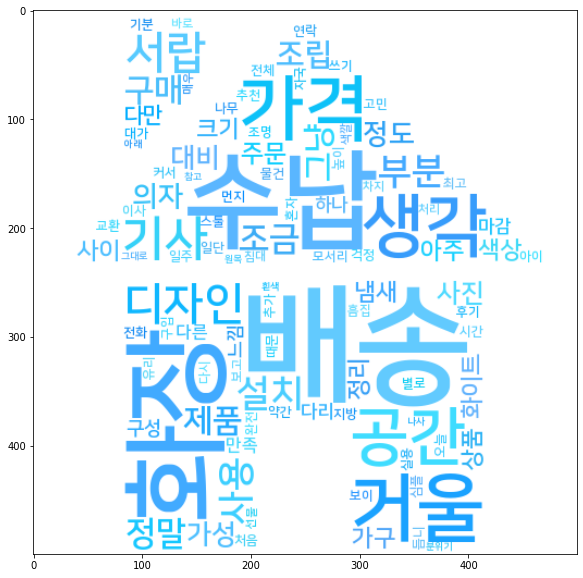

In [ ]:
# 화장대/콘솔
df5_copy = df5[:30000]
keywords = item_keyword(df5_copy, stopwords)
print(keywords)
item_wordcloud(df5_copy, stopwords, keywords)

scan vocabs ... 
num vocabs = 3477
done
{'조립': 97.0604306001808, '가격': 22.42496953658594, '배송': 20.348516195068132, '생각': 20.11507283591497, '서랍': 18.552645146071644, '디자인': 15.03663748760821, '조금': 12.441125040221555, '부분': 11.709751659772708, '사용': 11.460111445313398, '침대': 11.260007378126089, '유리': 10.867463986358297, '나사': 10.61975175463847, '협탁': 10.305320448193127, '구매': 9.9861075751159, '그냥': 9.539343733482882, '가성': 9.524429529560562, '책상': 9.351227322630034, '하나': 9.188549581399942, '혼자': 8.678894369123228, '정도': 8.283396572238836, '수납': 8.172554756855652, '제품': 7.821271524164026, '설명': 6.973902529589644, '사이': 6.895816057290895, '정말': 6.666218565261549, '나무': 6.371144312093759, '구성': 6.299686009655028, '대비': 6.2656710335132955, '여자': 6.171590966210935, '아주': 5.796383244071932, '화이트': 5.717942070550467, '완성': 5.234888857304965, '처음': 4.983565216224874, '느낌': 4.9698942246949125, '보고': 4.967097736862237, '시간': 4.950482702785492, '바퀴': 4.736948524147041, '물건': 4.736147946016764, 

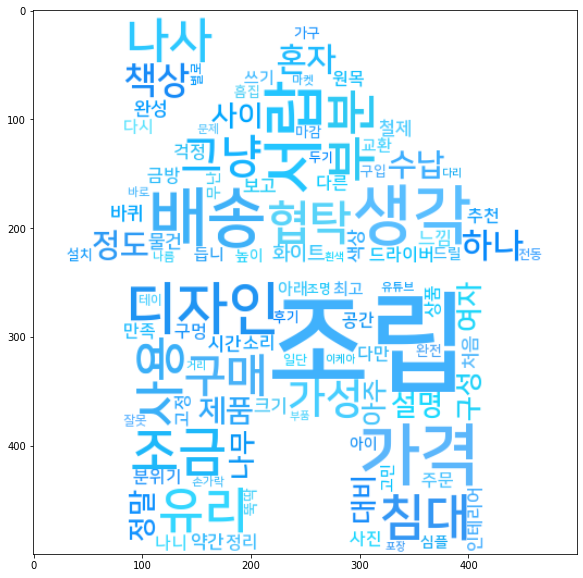

In [ ]:
# 서랍/수납장
df6_copy = df6[:30000]
keywords = item_keyword(df6_copy, stopwords)
print(keywords)
item_wordcloud(df6_copy, stopwords, keywords)

### __2. radar chart__
* Member: 가구 카테고리(6)
* KPI Name: 내구성/디자인/가격/배송/전체(5)
* KPI Value: 평점 수치

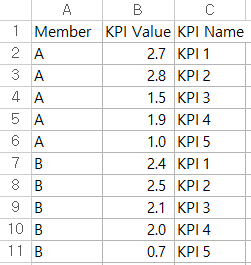

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/Shareddrives/컨퍼런스/for_model_final_0204.csv')

In [ ]:
df.groupby('item_category1').mean()

,total_score,review,item_sale_price,item_score,item_count,n1,n2,n3,n4,c6,dur_score,price_score,design_score,delivery_score,options
item_category1,,,,,,,,,,,,,,,
서랍/수납장,4.516548,62.385762,74266.054183,4.594518,2875.845647,3.496936,3.521036,3.452490,3.470826,3.725626,4.341189,4.485756,4.677210,4.486675,11.495858
소파,4.526042,65.214990,94368.547284,4.591742,4793.640624,3.501838,3.460917,3.458352,3.487361,3.722414,4.439285,4.512034,4.631603,4.458055,16.273380
의자,4.594928,54.439789,49236.299785,4.657898,3297.762315,3.504250,3.546150,3.469608,3.487612,3.942225,4.483250,4.544720,4.698982,4.593594,16.615792
침대,4.510821,79.644868,167661.045179,4.581209,2484.027847,3.536446,3.444686,3.552419,3.471846,3.606096,4.435011,4.514311,4.646116,4.377829,41.513617
테이블/책상,5.000000,57.504032,63565.784752,4.665253,7330.113223,3.516062,3.532029,3.435016,3.478519,5.384274,4.502397,4.585803,4.714642,4.552942,17.119097
화장대/콘솔,4.459396,69.285052,109433.189840,4.538161,1458.906280,3.490575,3.515741,3.474756,3.469752,3.482612,4.384131,4.465099,4.634360,4.284119,18.530429
